<a href="https://colab.research.google.com/github/KemasRaihan/Sentiment-Analysis-Of-Social-Media-Posts-Of-Phones-Using-Hybrid-Neural-Networks/blob/main/Customer_Reviews_Sentiment_Analysis_draft5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
# % matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
#For Qualitative Analysis
from itertools import groupby
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
# For fixing imbalanced data
from collections import Counter
from imblearn.over_sampling import SMOTE

In [5]:
# For Text Preprocessing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
nltk.download('words')
#nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import string

from sklearn.feature_extraction.text import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

import csv
import matplotlib.pyplot as plt
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [7]:
# For building the neural networks
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [8]:
# For evaluation
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

## GloVe Embedding

In [58]:
# Read GloVe Embedding

# Load GloVe word embeddings and create an Embeddings Dictionary
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/a2_glove.6B.100d.txt'

embeddings_index = dict()
f = open(filepath)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## Other

In [57]:
# Directory path
dirpath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/'

In [56]:
# Number of Epochs for each model to train
EPOCHS = 20

In [59]:
# Define classes
# There are 3 classes: negative, neutral and postive
num_of_classes = 3

**Raw Dataset**

PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships (https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)

In [60]:
# Import Raw Dataset
filepath = dirpath + 'Amazon_Unlocked_Mobile.csv'

# Control number of rows to read from csv file
nrows = 1000

df = pd.read_csv(filepath,nrows=nrows, encoding = 'latin')

**Display Graphs**

In [61]:
def display_graphs(history):
  fig, ax = plt.subplots(1, 2, figsize=(17, 5))
  ax[0].plot(history.history['acc'])
  ax[0].plot(history.history['val_acc'])

  ax[0].set_title('Model Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].legend(['train','test'], loc='upper left')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])

  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].legend(['train','test'], loc='upper left')
  plt.show()


# Raw Dataset Analysis

In [62]:
df.shape

(1000, 6)

In [63]:
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
8,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
9,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,3,It's battery life is great. It's very responsi...,0.0


**Drop NA Rows**

In [64]:
df.isnull().any()

Product Name    False
Brand Name       True
Price           False
Rating          False
Reviews         False
Review Votes     True
dtype: bool

In [65]:
df = df.dropna()

**Number Of Ratings Of Each Sentiment**

In [66]:
ratings = df['Rating'].values.tolist()

In [67]:
ratings[:5]

[5, 4, 5, 4, 4]

In [68]:
frequency = []

for i in range(1,6):
  frequency.append(ratings.count(i))

In [69]:
print(frequency)

[136, 57, 42, 61, 239]


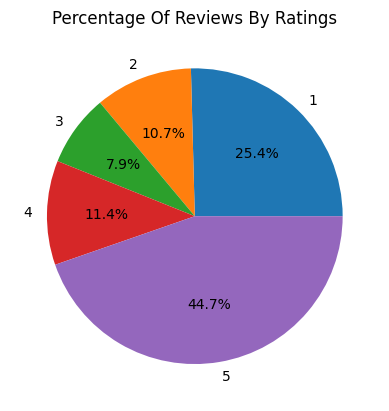

In [70]:
labels = [1,2,3,4,5]

fig, ax = plt.subplots()

ax.set_title('Percentage Of Reviews By Ratings')
ax.set_xticklabels(labels)

pps = ax.pie(frequency, labels=labels, autopct='%1.1f%%')

plt.show()

**Brand**

In [71]:
brands = sorted(df['Brand Name'].unique())

print(brands)

['Cedar Tree Technologies', 'Elephone', 'HTM', 'Huawei', 'Indigi', 'JUNING', 'Jethro', 'Lenovo', 'Nokia', 'OtterBox', 'Phone Baby', 'Plum', 'Samsung', 'e passion']


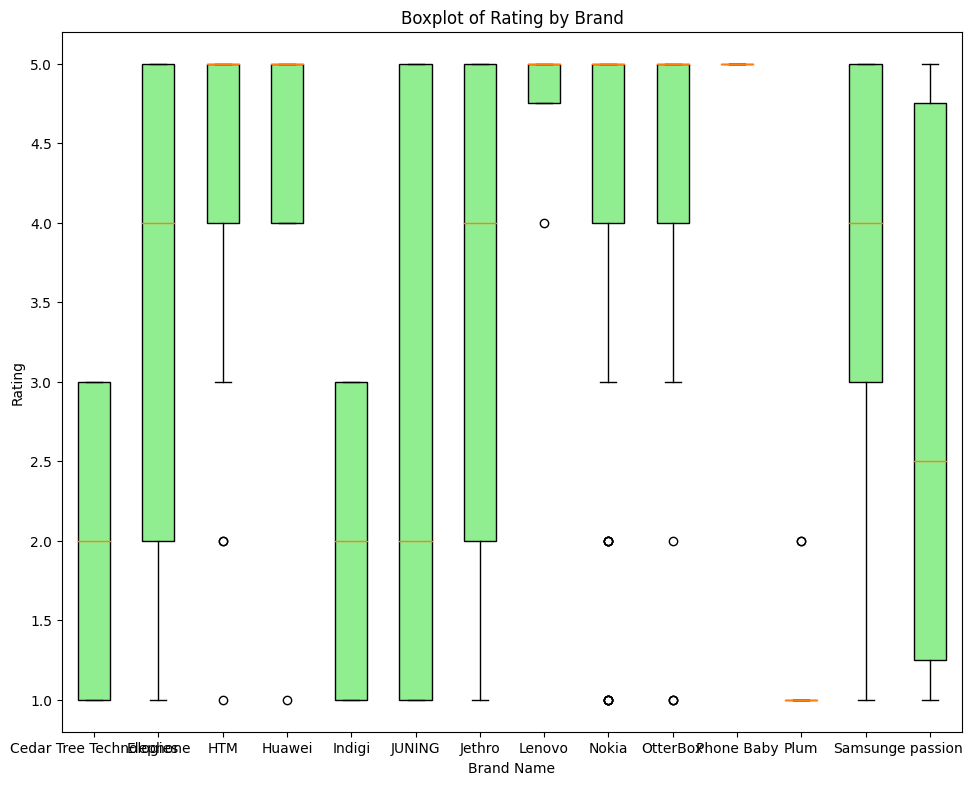

In [72]:
# Groupby by brand name
df_brands = df.groupby("Brand Name")

# initialise array to store each boxplot data
data = []

for brand in brands:
  # Group dataframe by the brand
  dfb = df_brands.get_group(brand)

  ratings = np.array(dfb['Rating'])

  data.append(ratings)

fig = plt.figure(figsize =(9, 7))

# Creating axes instance
ax = fig.add_axes([1, 1, 1, 1])

ax.set_title('Boxplot of Rating by Brand')
ax.set_ylabel('Rating')
ax.set_xlabel('Brand Name')
ax.set_xticklabels(brands)

# Creating plot
bp = ax.boxplot(data,
           patch_artist = True,
           boxprops = dict(facecolor = "lightgreen"))

# show plot
plt.show()


**Price**

In [73]:
ratings = sorted(df['Rating'].unique())

print(ratings)

[1, 2, 3, 4, 5]


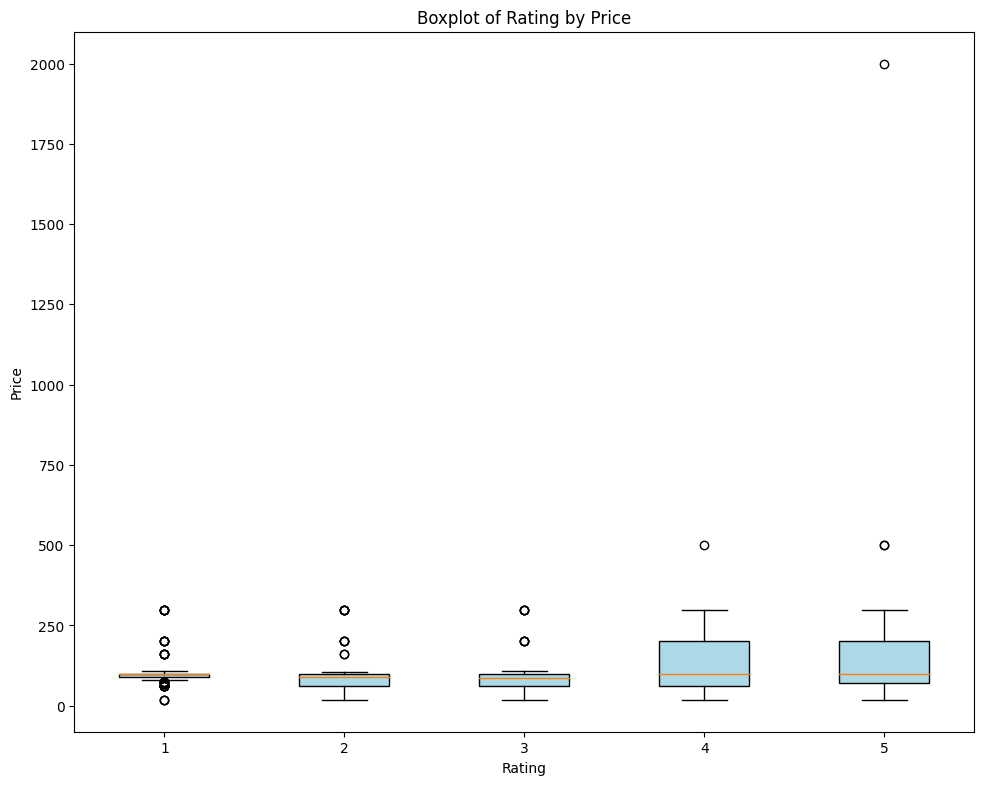

In [74]:
# Groupby by ratings
df_ratings = df.groupby("Rating")

# initialise array to store each boxplot data
data = []

for rating in ratings:
  # Group dataframe by the rating
  dfr = df_ratings.get_group(rating)

  prices = np.array(dfr['Price'])

  data.append(prices)

fig = plt.figure(figsize =(9, 7))

# Creating axes instance
ax = fig.add_axes([1, 1, 1, 1])

ax.set_title('Boxplot of Rating by Price')
ax.set_ylabel('Price')
ax.set_xlabel('Rating')
ax.set_xticklabels(ratings)

# Creating plot
bp = ax.boxplot(data,
           patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))
# show plot
plt.show()

# Reduce Classes

In [75]:
sentiments = []
ratings = df['Rating']

for rating in ratings:
  # if rating is 1 or 2 (negative) append 0 to sentiments array
  if rating < 3:
    sentiments.append(0)
  # if rating is 3 (neutral), append 1 to sentiments array
  elif rating == 3:
    sentiments.append(1)
  # if rating is 4 or 5 (positive), append 2 to sentiments array
  else:
    sentiments.append(2)


In [76]:
frequency = []

for i in range(3):
  frequency.append(sentiments.count(i))

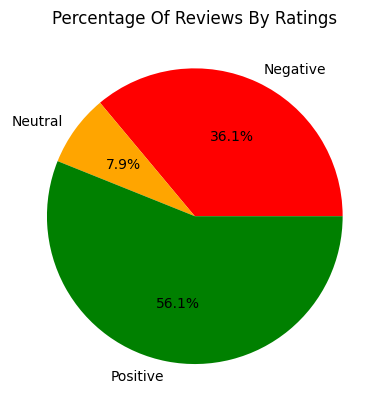

In [77]:
labels = ['Negative', 'Neutral', 'Positive']
colors = ['red', 'orange', 'green']
fig, ax = plt.subplots()

ax.set_title('Percentage Of Reviews By Ratings')
ax.set_xticklabels(labels)

pps = ax.pie(frequency, labels=labels, autopct='%1.1f%%', colors=colors)

plt.show()

In [78]:
# Append new column to original dataframe
df = df.assign(Sentiment=sentiments)

In [79]:
# Remove original Rating column
df = df.drop('Rating',axis=1)

In [80]:
df.tail()

,Product Name,Brand Name,Price,Reviews,Review Votes,Sentiment
715,"5.5"" Unlocked Smartphone Dual Sim Quad Core-JU...",JUNING,99.99,Let me begin by saying that this is a wonderfu...,4.0,2
716,"5.5"" Unlocked Smartphone Dual Sim Quad Core-JU...",JUNING,99.99,"When I received this phone, I was very Impress...",6.0,2
717,5.5-inch Unlocked Black Lenovo A850 3g Smartph...,Lenovo,500.00,It's very very good,0.0,2
718,5.5-inch Unlocked Black Lenovo A850 3g Smartph...,Lenovo,500.00,good,0.0,2
719,5.5-inch Unlocked Black Lenovo A850 3g Smartph...,Lenovo,500.00,Excellent seller recommend 100%,0.0,2


# Preprocessing Text

In [81]:
reviews = df['Reviews']

In [82]:
# Reviews before preprocessing
reviews.head()

0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object

In [83]:
def preprocess_text(review):
    # Remove stopwords 'n punctuation
    sw = stopwords.words('english')

    # Convert to lowercase
    review = review.lower()

     # Remove words with non-ASCII characters
    review = re.sub(r'[^\x00-\x7F]+',' ', review)

    # Remove stop words
    words = review.split()
    words = [word for word in words if word not in set(stopwords.words('english'))]

    review = " ".join(words)

    return review

In [84]:
reviews = reviews.apply(preprocess_text)

In [85]:
# Reviews after preprocessing
reviews.head()

0    feel lucky found used (phone us & used hard al...
1    nice phone, nice grade pantach revue. clean se...
2                                              pleased
3       works good goes slow sometimes good phone love
4    great phone replace lost phone. thing volume b...
Name: Reviews, dtype: object

# Qualitative Analysis

In [485]:
# Creating an object using groupby
df_sentiments = df.groupby('Sentiment')

In [486]:
def generate_wordcloud(sentiment, ax, title, cm):

    # Group dataframe by the sentiment
    df = df_sentiments.get_group(sentiment)

    # Creating the text variable
    text = " ".join(review for review in df['Reviews'])

    # Creating word cloud with text as argument in .generate() method
    wordcloud = WordCloud(collocations=False, background_color='white', colormap=cm).generate(text)

    # Display the generated Word Cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)
    # ax.show()

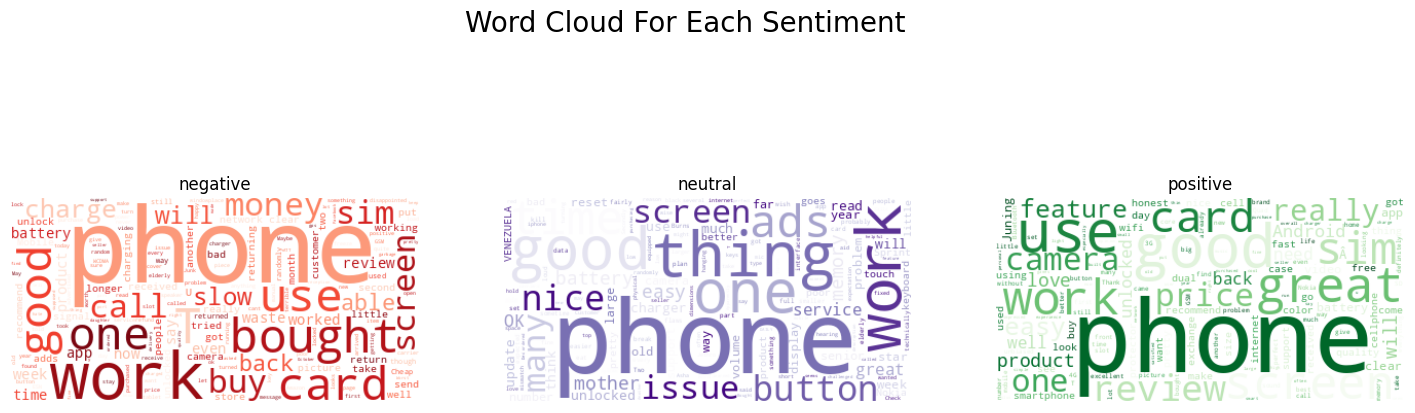

In [487]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Word Cloud For Each Sentiment', fontsize=20)

# Generate wordcloud of negative reviews
generate_wordcloud(0, axes[0],  'negative', 'Reds')

# Generate wordcloud of neutral reviews
generate_wordcloud(1, axes[1],  'neutral', 'Purples')

# Generate wordcloud of positive reviews
generate_wordcloud(2, axes[2],  'positive', 'Greens')

plt.show()

# Tokenize

In [96]:
# Find the length of longest review
max_length = reviews.apply(lambda x: len(x.split())).max()
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(reviews)
vocab_size = len(word_tokenizer.word_index) + 1

In [97]:
def tokenize(review):
  # Convert text to sequences
  encoded_review = word_tokenizer.texts_to_sequences(review)

  # Pad reviews
  padded_review = pad_sequences(encoded_review, maxlen=max_length, padding='post')

  return padded_review

In [98]:
# Map each unique word index with its GloVe vector

embedding_dim = 100

# Initialize an empty matrix with zeros, where the number of rows is determined by the vocabulary size (vocab_size),
# and the number of columns is set to 100, matching the dimensionality of the GloVe word embeddings.
embedding_matrix = np.zeros((vocab_size, 100))

# Iterate through each word in the tokenizer's word index
for word, i in t.word_index.items():
  # Retrieve the GloVe word embedding vector for the current word
    embedding_vector = embeddings_index.get(word)
    # Check if the word has a corresponding embedding in the GloVe model
    if embedding_vector is not None:
      # If an embedding exists, update the corresponding row in the embedding matrix
        # with the GloVe word embedding vector for the current word.
        embedding_matrix[i] = embedding_vector

In [99]:
print(embedding_matrix[:5])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

# Define Training, Validation and Testing Dataset

In [100]:
one_hot_encoded_Y = pd.get_dummies(sentiments).values

In [101]:
one_hot_encoded_Y.shape

(535, 3)

In [102]:
reviews.shape

(535,)

In [103]:
# Firstly split them into the training dataset and the rest as remaining dataset for validation and testing
train_reviews, remain_reviews, y_train, y_rem = train_test_split(reviews, one_hot_encoded_Y, train_size=0.8)

# Split the remaining dataset for validation and testing
valid_reviews, test_reviews, y_valid, y_test = train_test_split(remain_reviews, y_rem, train_size=0.5)

In [104]:
print(train_reviews[:5])

269                              thank's best supply!!!!
139                                                 good
651    returned it...don't bother..u make calls text ...
508    slow, worked fine. however 2 weeks charge. dia...
498    attractive phone work upon arrival. would reco...
Name: Reviews, dtype: object


In [105]:
train_reviews_padded = tokenize(train_reviews)

valid_reviews_padded = tokenize(valid_reviews)

In [106]:
train_reviews_padded.shape

(428, 398)

In [107]:
y_train.shape

(428, 3)

# Model Training With:

## Simple Neural Network (SNN)

In [108]:
SNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length , trainable=False),
    Flatten(),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for Simple Neural Network model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
SNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

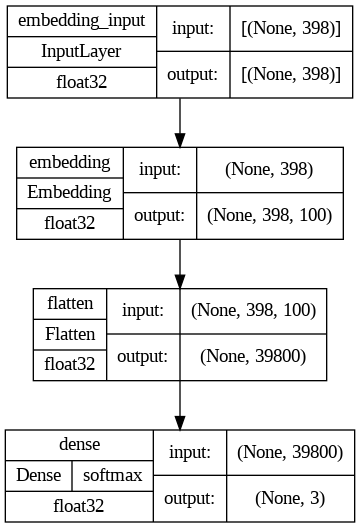

In [109]:
plot_model(
  SNN,
  show_shapes = True,
  show_dtype = True,
  show_layer_activations = True
)

In [110]:
SNN_history = SNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 1s 18ms/step - loss: 0.9206 - acc: 0.5748 - val_loss: 0.7538 - val_acc: 0.8113
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.7640 - acc: 0.7827 - val_loss: 0.7141 - val_acc: 0.8113
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6922 - acc: 0.8505 - val_loss: 0.6862 - val_acc: 0.8302
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6402 - acc: 0.8598 - val_loss: 0.6672 - val_acc: 0.7736
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.5988 - acc: 0.8458 - val_loss: 0.6525 - val_acc: 0.7736
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.5627 - acc: 0.8645 - val_loss: 0.6447 - val_acc: 0.7925
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 0.5322 - acc: 0.8715 - val_loss: 0.6270 - val_acc: 0.8113
Epoch 8/20
14/14 [==============================] - 0s 5ms/step - loss: 0.5042 - acc: 0.8

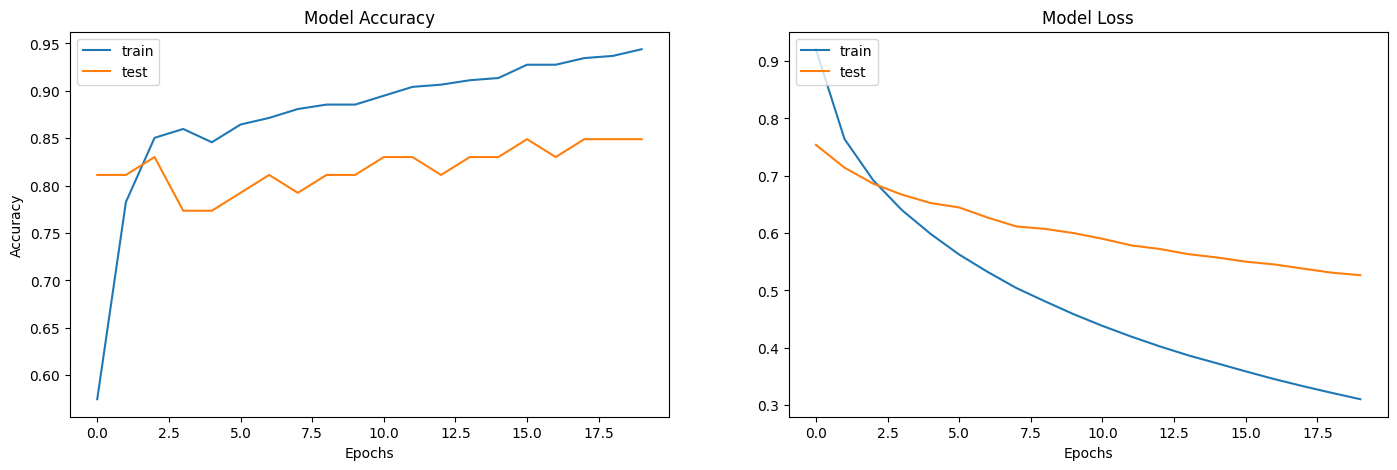

In [111]:
display_graphs(SNN_history)

In [112]:
# Define file path to save/load SNN model
filename = 'SNN_sentiment_predictor.keras'
filepath_SNN = dirpath + '/models/' + filename

In [113]:
# save SNN model
keras.saving.save_model(SNN, filepath_SNN)

## Convolutional Neural Network (CNN)

In [114]:
CNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for CNN model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

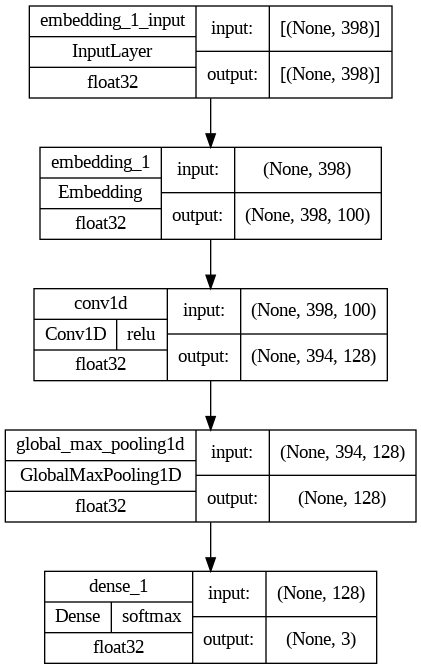

In [115]:
plot_model(
  CNN,
  show_shapes = True,
  show_dtype = True,
  show_layer_activations = True
)

In [116]:
CNN_history = CNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 1s 38ms/step - loss: 0.9041 - acc: 0.5841 - val_loss: 0.7632 - val_acc: 0.6792
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 0.7427 - acc: 0.7453 - val_loss: 0.6852 - val_acc: 0.7358
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.6568 - acc: 0.8084 - val_loss: 0.6370 - val_acc: 0.8113
Epoch 4/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5871 - acc: 0.8294 - val_loss: 0.5884 - val_acc: 0.8491
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.5270 - acc: 0.8715 - val_loss: 0.5524 - val_acc: 0.8491
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.4746 - acc: 0.8949 - val_loss: 0.5073 - val_acc: 0.8868
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.4329 - acc: 0.9019 - val_loss: 0.4916 - val_acc: 0.8868
Epoch 8/20
14/14 [==============================] - 0s 9ms/step - loss: 0.3904 - acc: 0.

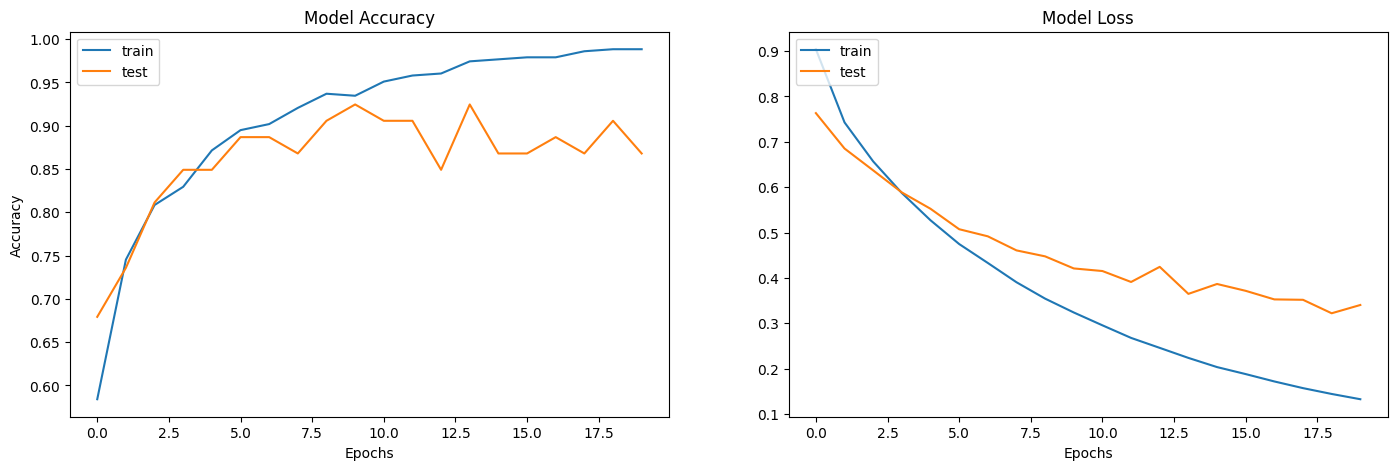

In [117]:
display_graphs(CNN.history)

In [118]:
# Define file path to save/load CNN model
filename = 'CNN_sentiment_predictor.keras'
filepath_CNN = dirpath + '/models/' + filename

In [119]:
# save CNN model
keras.saving.save_model(CNN, filepath_CNN)

## Long-Short Term Memory (LSTM)

In [120]:
# Build an LSTM model
LSTM_ = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Flatten(),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for LSTM model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
LSTM_.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

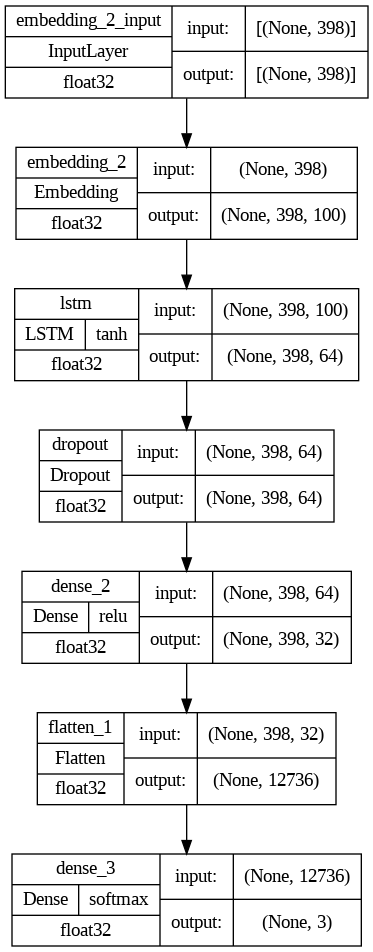

In [121]:
plot_model(
    LSTM_,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [122]:
# Train the model
LSTM_history = LSTM_.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 4s 63ms/step - loss: 0.9404 - acc: 0.5374 - val_loss: 0.7647 - val_acc: 0.6038
Epoch 2/20
14/14 [==============================] - 0s 18ms/step - loss: 0.8541 - acc: 0.5818 - val_loss: 0.7274 - val_acc: 0.6792
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 0.8299 - acc: 0.6285 - val_loss: 0.7204 - val_acc: 0.6038
Epoch 4/20
14/14 [==============================] - 0s 17ms/step - loss: 0.8101 - acc: 0.6449 - val_loss: 0.7168 - val_acc: 0.6226
Epoch 5/20
14/14 [==============================] - 0s 17ms/step - loss: 0.7853 - acc: 0.6822 - val_loss: 0.6832 - val_acc: 0.7170
Epoch 6/20
14/14 [==============================] - 0s 17ms/step - loss: 0.7454 - acc: 0.7103 - val_loss: 0.6608 - val_acc: 0.7925
Epoch 7/20
14/14 [==============================] - 0s 16ms/step - loss: 0.6936 - acc: 0.7290 - val_loss: 0.6267 - val_acc: 0.8302
Epoch 8/20
14/14 [==============================] - 0s 17ms/step - loss: 0.6518 - a

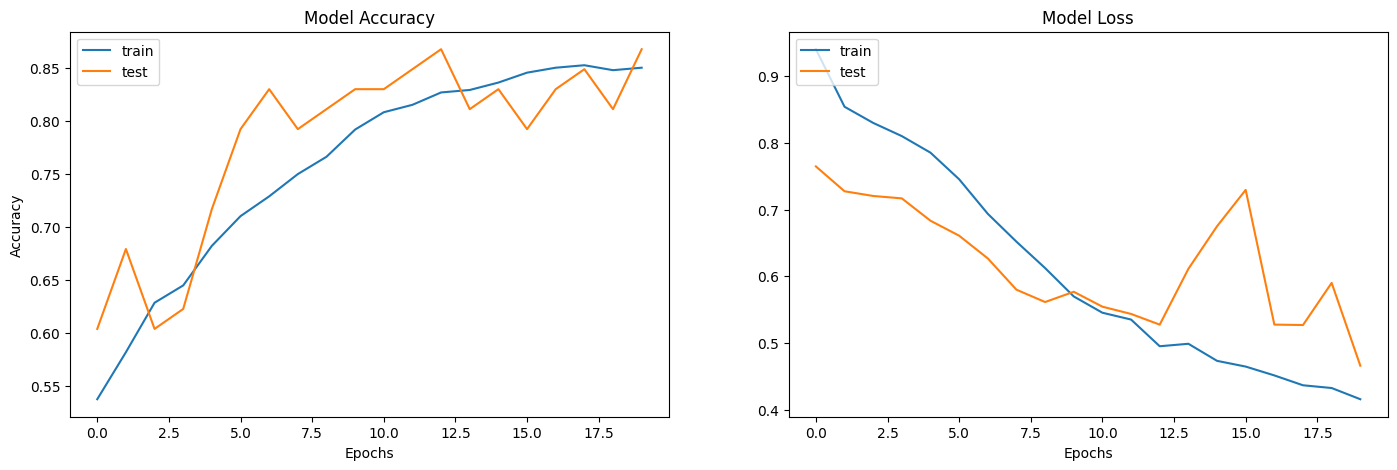

In [123]:
display_graphs(LSTM_.history)

In [124]:
# Define file path to save/load LSTM model
filename = 'LSTM_sentiment_predictor.keras'
filepath_LSTM = dirpath + '/models/' + filename

In [125]:
# save LSTM model
keras.saving.save_model(LSTM_, filepath_LSTM)

## CNN + LSTM

In [126]:
CNN_LSTM = Sequential([
  Embedding(vocab_size, embedding_dim, input_length=max_length),
  Conv1D(128, kernel_size=5, activation = "relu"),
  MaxPooling1D(pool_size=4),
  LSTM(64, return_sequences=True),
  Dropout(0.2),
  Dense(32, activation='relu'),
  Flatten(),
  Dense(num_of_classes, activation='softmax')
])

# Define optimiser for CNN + Dense model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

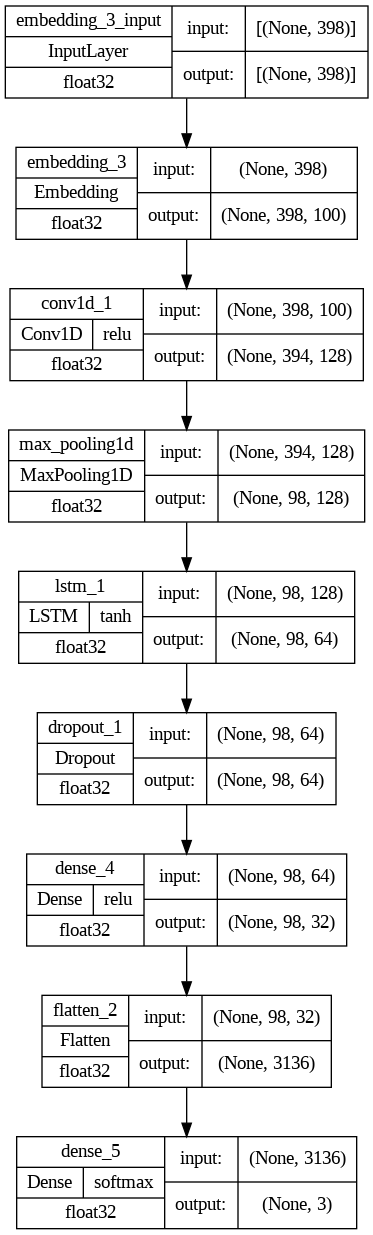

In [127]:
plot_model(
    CNN_LSTM,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [128]:
# Train the CNN + Dense model
CNN_LSTM_history = CNN_LSTM.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
14/14 [==============================] - 5s 157ms/step - loss: 0.9774 - acc: 0.5047 - val_loss: 0.8570 - val_acc: 0.6038
Epoch 2/20
14/14 [==============================] - 1s 106ms/step - loss: 0.9129 - acc: 0.5514 - val_loss: 0.8153 - val_acc: 0.6038
Epoch 3/20
14/14 [==============================] - 2s 136ms/step - loss: 0.9042 - acc: 0.5514 - val_loss: 0.8147 - val_acc: 0.6038
Epoch 4/20
14/14 [==============================] - 2s 178ms/step - loss: 0.8995 - acc: 0.5514 - val_loss: 0.7902 - val_acc: 0.6038
Epoch 5/20
14/14 [==============================] - 1s 110ms/step - loss: 0.8888 - acc: 0.5514 - val_loss: 0.7778 - val_acc: 0.6038
Epoch 6/20
14/14 [==============================] - 1s 101ms/step - loss: 0.8794 - acc: 0.5444 - val_loss: 0.7968 - val_acc: 0.6038
Epoch 7/20
14/14 [==============================] - 2s 112ms/step - loss: 0.8761 - acc: 0.5491 - val_loss: 0.7553 - val_acc: 0.6038
Epoch 8/20
14/14 [==============================] - 1s 101ms/step - loss: 0.

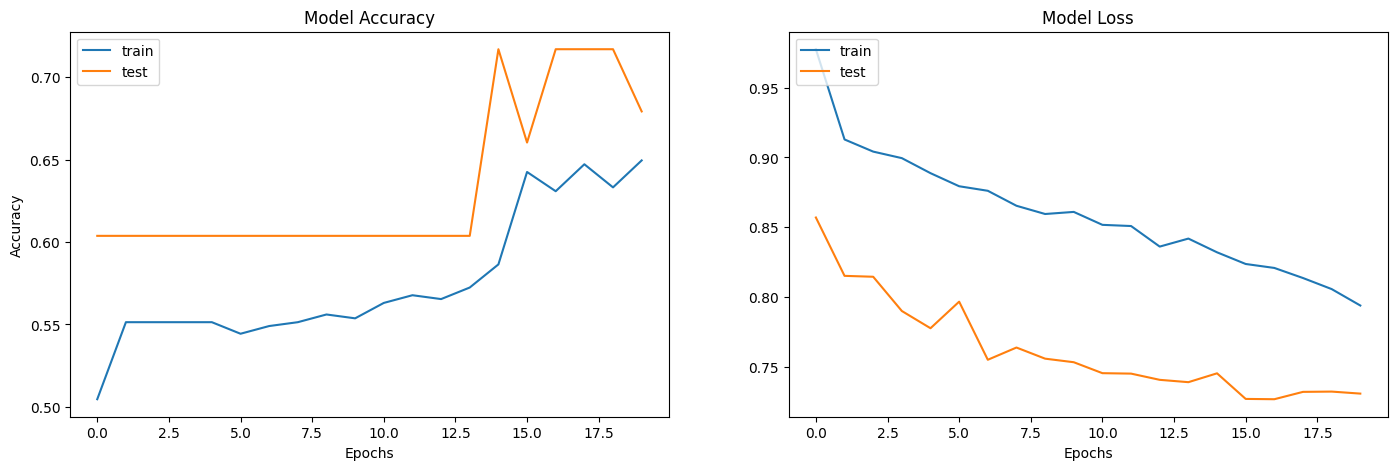

In [129]:
display_graphs(CNN_LSTM.history)

In [130]:
# Define file path to save/load CNN + LSTM model
filename = 'CNN_LSTM_sentiment_predictor.keras'
filepath_CNN_LSTM = dirpath + '/models/' + filename

In [131]:
# save CNN + LSTM model
keras.saving.save_model(CNN_LSTM, filepath_CNN_LSTM)

# Load Trained Models

**SNN**

In [43]:
# Define file path to save/load SNN model
filename = 'SNN_sentiment_predictor.keras'
filepath_SNN = dirpath + '/models/' + filename

# load SNN model
SNN = tf.keras.saving.load_model(
    filepath_SNN, custom_objects=None, compile=True
)

**CNN**

In [44]:
# Define file path to save/load CNN model
filename = 'CNN_sentiment_predictor.keras'
filepath_CNN = dirpath + '/models/' + filename

# load CNN model
CNN = tf.keras.saving.load_model(
    filepath_CNN, custom_objects=None, compile=True
)

**LSTM**

In [45]:
# Define file path to save/load LSTM model
filename = 'LSTM_sentiment_predictor.keras'
filepath_LSTM = dirpath + '/models/' + filename

# load LSTM model
LSTM_ = tf.keras.saving.load_model(
    filepath_LSTM, custom_objects=None, compile=True
)

**CNN + LSTM**

In [46]:
# Define file path to save/load CNN + LSTM model
filename = 'CNN_LSTM_sentiment_predictor.keras'
filepath_CNN_LSTM = dirpath + '/models/' + filename

# load CNN + LSTM model
CNN_LSTM = tf.keras.saving.load_model(
    filepath_CNN_LSTM, custom_objects=None, compile=True
)

# Evaluation

In [132]:
test_reviews_padded = tokenize(test_reviews)

In [133]:
names = ['SNN', 'CNN', 'LSTM', 'CNN + LSTM']
models = [SNN, CNN, LSTM_, CNN_LSTM]

In [134]:
def calc_accuracy(model):
  # Predictions on the Test Set
  score = model.evaluate(test_reviews_padded, y_test, verbose=1)
  return score

In [135]:
def plot_scores_bar(models, names):
  accuracy_scores = []
  test_scores = []
  test_accuracies = []

  # For each model calculate the accuracy scores
  for model in models:
    accuracy_scores.append(calc_accuracy(model))

  # Extract each test scores and test accuracy of each model
  for score in accuracy_scores:
    test_scores.append(score[0])
    test_accuracies.append(score[1])

  X_axis = np.arange(len(names))

  plt.bar(X_axis - 0.2, test_scores, 0.4, label = 'Test Scores')
  plt.bar(X_axis + 0.2, test_accuracies, 0.4, label = 'Test Accuracies')

  plt.xticks(X_axis, names)
  plt.xlabel("Model")
  #plt.ylabel("Score")
  plt.title("Scores")
  plt.legend()
  plt.show()


2/2 [==============================] - 0s 11ms/step - loss: 0.7627 - acc: 0.5926


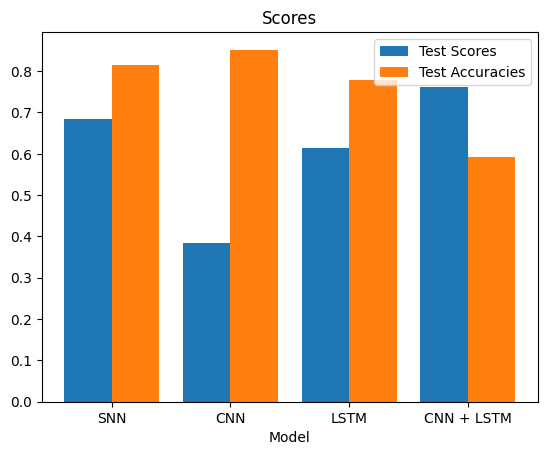

In [136]:
plot_scores_bar(models,names)

**Accuracy, precision, recall and f1 scores**

In [137]:
# Convert multidimensional y array to a one-dimensional array
def convert_y_to_1D(y):
  return np.argmax(y, axis=1)

In [138]:
#Calculates accuracy, precision, recall, f1 and specificity from predicted and true results
def calc_scores(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Calculate accuracy score
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision score
  precision = precision_score(y_true, y_pred, average='weighted')

  # Calculate recall score
  recall = recall_score(y_true, y_pred, average='weighted')

  # Calculate f1 score
  f1 = f1_score(y_true, y_pred, average='weighted')

  return [accuracy, precision, recall, f1]

In [139]:
#Calculates accuracy, precision, recall, f1 and specificity from predicted and true results
def calc_scores(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Calculate accuracy score
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision score
  precision = precision_score(y_true, y_pred, average='weighted')

  # Calculate recall score
  recall = recall_score(y_true, y_pred, average='weighted')

  # Calculate f1 score
  f1 = f1_score(y_true, y_pred, average='weighted')

  return [accuracy, precision, recall, f1]

In [140]:
def create_scores_dict(model, name):
  scores_train = calc_scores(model, train_reviews_padded, y_train)
  scores_valid = calc_scores(model, valid_reviews_padded, y_valid)
  dict_ = {'Accuracy (Train)' : scores_train[0],
          'Accuracy (Valid)' : scores_valid[0],
            'Precision (Train)' : scores_train[1],
            'Precision (Valid)' : scores_valid[1],
            'Recall (Train)' : scores_train[2],
          'Recall (Valid)' : scores_valid[2],
            'F1 (Train)' : scores_train[3],
            'F1 (Valid)' : scores_valid[3]
            }
  return dict_

In [141]:
# Define the model names and their scores for both training and validation set
models = {'SNN' : create_scores_dict(SNN, 'SNN'),
          'CNN' : create_scores_dict(CNN, 'CNN'),
          'LSTM' : create_scores_dict(LSTM_, 'LSTM'),
          'CNN + LSTM' : create_scores_dict(CNN_LSTM, 'CNN_LSTM')
}

#Create a dataframe table of the dictionary of the models
scores = pd.DataFrame(models).T
scores

2/2 [==============================] - 0s 9ms/step


,Accuracy (Train),Accuracy (Valid),Precision (Train),Precision (Valid),Recall (Train),Recall (Valid),F1 (Train),F1 (Valid)
SNN,0.946262,0.849057,0.948859,0.816262,0.946262,0.849057,0.942938,0.831361
CNN,0.988318,0.867925,0.988443,0.865747,0.988318,0.867925,0.988260,0.855332
LSTM,0.862150,0.867925,0.861584,0.841836,0.862150,0.867925,0.838169,0.853140
CNN + LSTM,0.635514,0.679245,0.577819,0.654574,0.635514,0.679245,0.604172,0.666667


# Live Prediction

In [142]:
input_review = input("Enter review: ")

Enter review: hello


In [143]:
input_review_processed = preprocess_text(input_review)

print(input_review_processed)

hello


In [144]:
input_review_tokenized = tokenize(input_review_processed)

print(input_review_tokenized)

[[   0    0    0 ...    0    0    0]
 [ 346    0    0 ...    0    0    0]
 [2724    0    0 ...    0    0    0]
 [2724    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [50]:
input_review_tokenized.shape

(5, 398)

In [51]:
SNN_pred = SNN.predict(input_review_tokenized)

CNN_pred = CNN.predict(input_review_tokenized)

LSTM_pred = LSTM_.predict(input_review_tokenized)

CNN_LSTM_pred = CNN_LSTM.predict(input_review_tokenized)

print("Review: ", input_review)
print("SNN Prediction: ", SNN_pred)
print("CNN Prediction: ", CNN_pred)
print("LSTM Prediction: ", LSTM_pred)
print("CNN + LSTM Prediction: ", CNN_LSTM_pred)

1/1 [==============================] - 1s 600ms/step
Review:  hello
SNN Prediction:  [[0.33204195 0.3229249  0.3450331 ]
 [0.44539562 0.23412503 0.3204794 ]
 [0.3327241  0.28870064 0.3785753 ]
 [0.3327241  0.28870064 0.3785753 ]
 [0.33204195 0.3229249  0.3450331 ]]
CNN Prediction:  [[0.32602268 0.3029412  0.3710361 ]
 [0.5746776  0.17680435 0.24851803]
 [0.31969738 0.22691962 0.45338297]
 [0.31969738 0.22691962 0.45338297]
 [0.32602268 0.3029412  0.3710361 ]]
LSTM Prediction:  [[0.2715439  0.1295149  0.5989412 ]
 [0.3966067  0.13697587 0.4664175 ]
 [0.1724794  0.10134733 0.7261732 ]
 [0.1724794  0.10134733 0.7261732 ]
 [0.2715439  0.1295149  0.5989412 ]]
CNN + LSTM Prediction:  [[0.29009825 0.08557712 0.6243246 ]
 [0.2899384  0.08550759 0.62455404]
 [0.29010352 0.0856101  0.62428635]
 [0.29010352 0.0856101  0.62428635]
 [0.29009825 0.08557712 0.6243246 ]]


In [52]:
sample_review = df['Reviews'][3]
print(sample_review)

It works good but it goes slow sometimes but its a very good phone I love it


In [53]:
print(len(sample_review))

76


In [54]:
sample_review_processed = preprocess_text(sample_review)

sample_review_tokenized = tokenize(sample_review_processed)

print(sample_review_tokenized)

[[1094    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [ 346    0    0 ...    0    0    0]]


In [55]:
sample_review_tokenized.shape

(46, 398)

#